# TASK 2  - Dimensionality reduction

## Embedding ways:
- Embed the whole data -> plot each group separately : **unsatisfactory visualization, does not provide information about each group or each patient.**
- Embed each group separately -> plot each patient separately : **satisfactory, easy to compare patients while also providing enough seperation between groups.**
- Embed each patient separately -> plot each patient separately : **To much variation, hard to compare each patient**

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import LabelEncoder

from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
import umap

import pickle

## Helper functions

In [4]:
def get_cells_of_group_without_columns(df, group, columns):
    return df[df.group == group][df.columns.difference(columns)]

def get_cells_of_patient_without_columns(df, id_, columns):
    return df[df.id == id_][df.columns.difference(columns)]

## Possible candidates
- tsne
- umap
- MDS

## Import files

In [2]:
dfs = pd.read_csv("ModifiedDATA/scaled_ra.csv")

In [3]:
dfs.describe()

,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,id
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,1.150588,1.333476,0.118680,0.085666,0.095650,0.671779,0.307882,1.880021,2.817956,0.984007,0.604480,0.485726,20.500000
std,1.220329,1.838250,0.419028,0.282540,0.385329,1.359591,0.853568,1.754079,1.905254,1.686048,1.114777,1.217038,11.543404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034593,0.222168,0.000000,0.000000,0.000000,10.750000
50%,0.452590,0.380735,0.000000,0.000000,0.000000,0.000000,0.000000,1.471067,3.798173,0.000000,0.022598,0.000000,20.500000
75%,2.432927,1.983169,0.000000,0.000000,0.000000,0.396897,0.000000,3.459549,4.315451,0.982516,0.592855,0.109779,30.250000
max,6.689613,9.361942,6.185456,9.160339,5.356280,6.788544,5.775514,7.477199,6.020727,8.772834,6.866529,9.270154,40.000000


## 1. Embed the whole data -> plot each group seperatly
- The reduction algrithms are trained on both "control" and "diseased" cells combined.

### Subsampling

In [4]:
# subsample df
SAMPLE_SIZE = 20000
subsample = dfs.sample(SAMPLE_SIZE)
sTrain = subsample[dfs.columns.difference(["id","group"])]

leG = LabelEncoder() # Used to label each group
label_group = leG.fit_transform(subsample.group)

leI = LabelEncoder()
label_id = leI.fit_transform(subsample.id)

### Embedd

In [46]:
tSNE = TSNE(n_components=2, 
            perplexity=30, 
            metric="euclidean",
            random_state=42)

up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)

%time embedding_tSNE = tsne.fit(sTrain.values)
%time embedding_UMAP = up.fit_transform(sTrain)

CPU times: user 57.8 s, sys: 1.61 s, total: 59.4 s
Wall time: 1min 1s


/usr/local/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/local/lib/python3.7/site-packages/umap/utils.py", line 

CPU times: user 16.3 s, sys: 300 ms, total: 16.6 s
Wall time: 16.3 s


### Ploter

In [83]:
# Plot embedding
def plot_embedding(embedding):
    embedding_df = pd.DataFrame(embedding, columns=["fstAxis","sndAxis"])
    embedding_df["group"]=subsample.group.values
    
    def trim_axs(axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        """
        axs = axs.flat
        for ax in axs[N:]:
            ax.remove()
        return axs[:N]
    
    def plot_group(ax, group, group_name):
        group_color = {'control':'green',
                      'diseased':'red'}
        ax.scatter(group.fstAxis, group.sndAxis, c=group_color[group_name])
        ax.set_title(group_name)
        
    
    fig, axs = plt.subplots(1,2,figsize = (15,8))
    axs = trim_axs(axs, 2)
    for ax, group_name in zip(axs, ["control","diseased"]):
        plot_group(ax, embedding_df[embedding_df.group==group_name], group_name)
    
    plt.show

### Plot TSNE

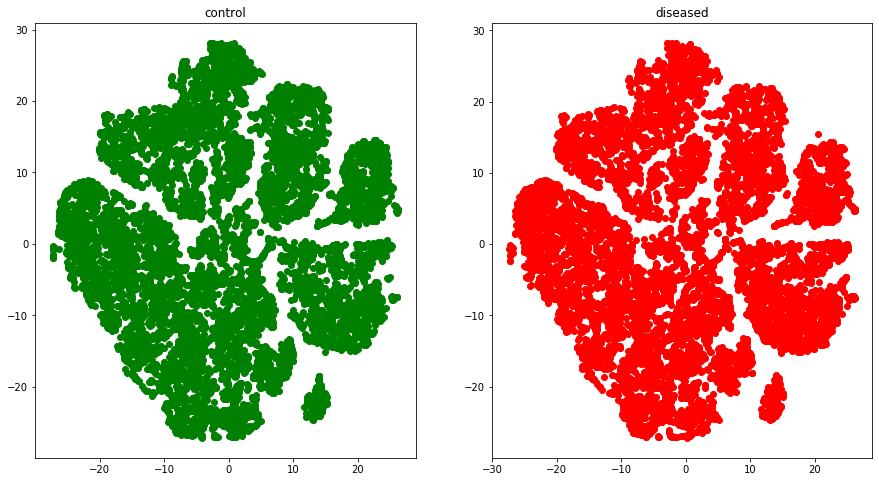

In [84]:
plot_embedding(embedding_tSNE)

### Plot UMAP of standardized data

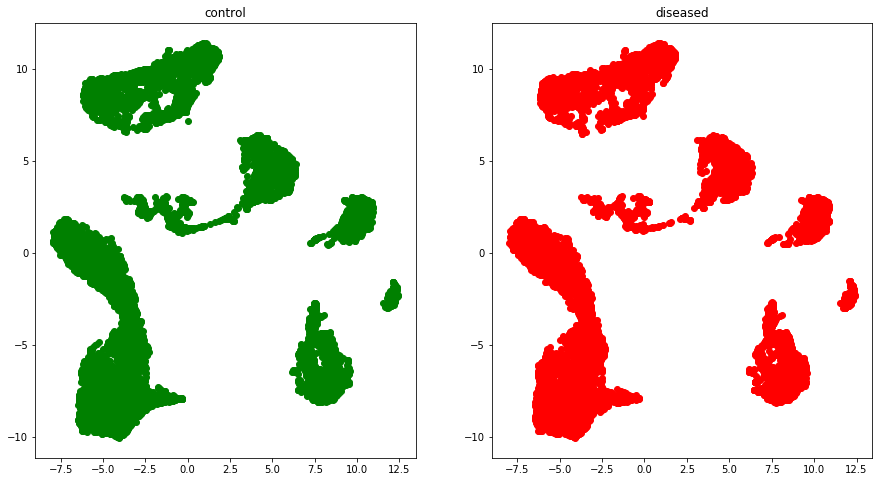

In [85]:
plot_embedding(embedding_UMAP)

### NOTE: 
- The results from both TSNE and UMAP suggests possibly at least 6 clusters, even though this is just a subsampling. from this we can fit a gmm with 6 components and compare it to gmm with fewer and more components.

## 2. Embed each group separately -> plot each patient separately
- The embedding algorithms are trainded on "control" and "diseased" cells seperated

### Embedd

In [7]:
groupembedding_tSNE = dict()
groupembedding_UMAP = dict()

tsne = TSNE(n_components=2, perplexity=30, 
            learning_rate=20, n_iter=1000, 
            random_state=0)
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)

groups = ["control", "diseased"]

for g in groups:
    group = subsample[subsample.group == g]
    group_cells = group[group.columns.difference(["id","group"])]
    
    groupembedding_tSNE[g] = tsne.fit(group_cells.values)
    groupembedding_UMAP[g] = up.fit_transform(group_cells)

/usr/local/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/local/lib/python3.7/site-packages/umap/utils.py", line 

### Ploter

In [80]:
def plot_each_patient(embedding):
    
    def get_embedding_with_id(embedding, group_name, subsample):
        group = embedding[group_name]
        emb_df = pd.DataFrame(group, columns=["fstAxis","sndAxis"])
        emb_df["id"] = subsample[subsample.group==group_name].id.values
        return emb_df
        
    control_df = get_embedding_with_id(embedding, "control", subsample)
    diseased_df = get_embedding_with_id(embedding, "diseased", subsample)

    def plotResP(ax, cells_of_id, id_nr):
        if(id_nr>20): 
            color= "red" # control patients
        else: 
            color ="green" # diseased patients
        ax.scatter(cells_of_id.fstAxis, cells_of_id.sndAxis, c=color)
        ax.set_title(id_nr)
        
    def trim_axs(axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        """
        axs = axs.flat
        for ax in axs[N:]:
            ax.remove()
        return axs[:N]
    
    
    # split into ids 
    fig, axs = plt.subplots(10,4,figsize = (30,65))
    axs = trim_axs(axs, 40)
    
    for id_  in range(1,21):
        cells_of_id = control_df[control_df.id == id_]
        plotResP(axs[id_-1], cells_of_id, id_)
        cells_of_id = diseased_df[diseased_df.id == id_+20]
        plotResP(axs[id_+19], cells_of_id, id_+20)
        
    plt.show

### Plot tSNE embedding

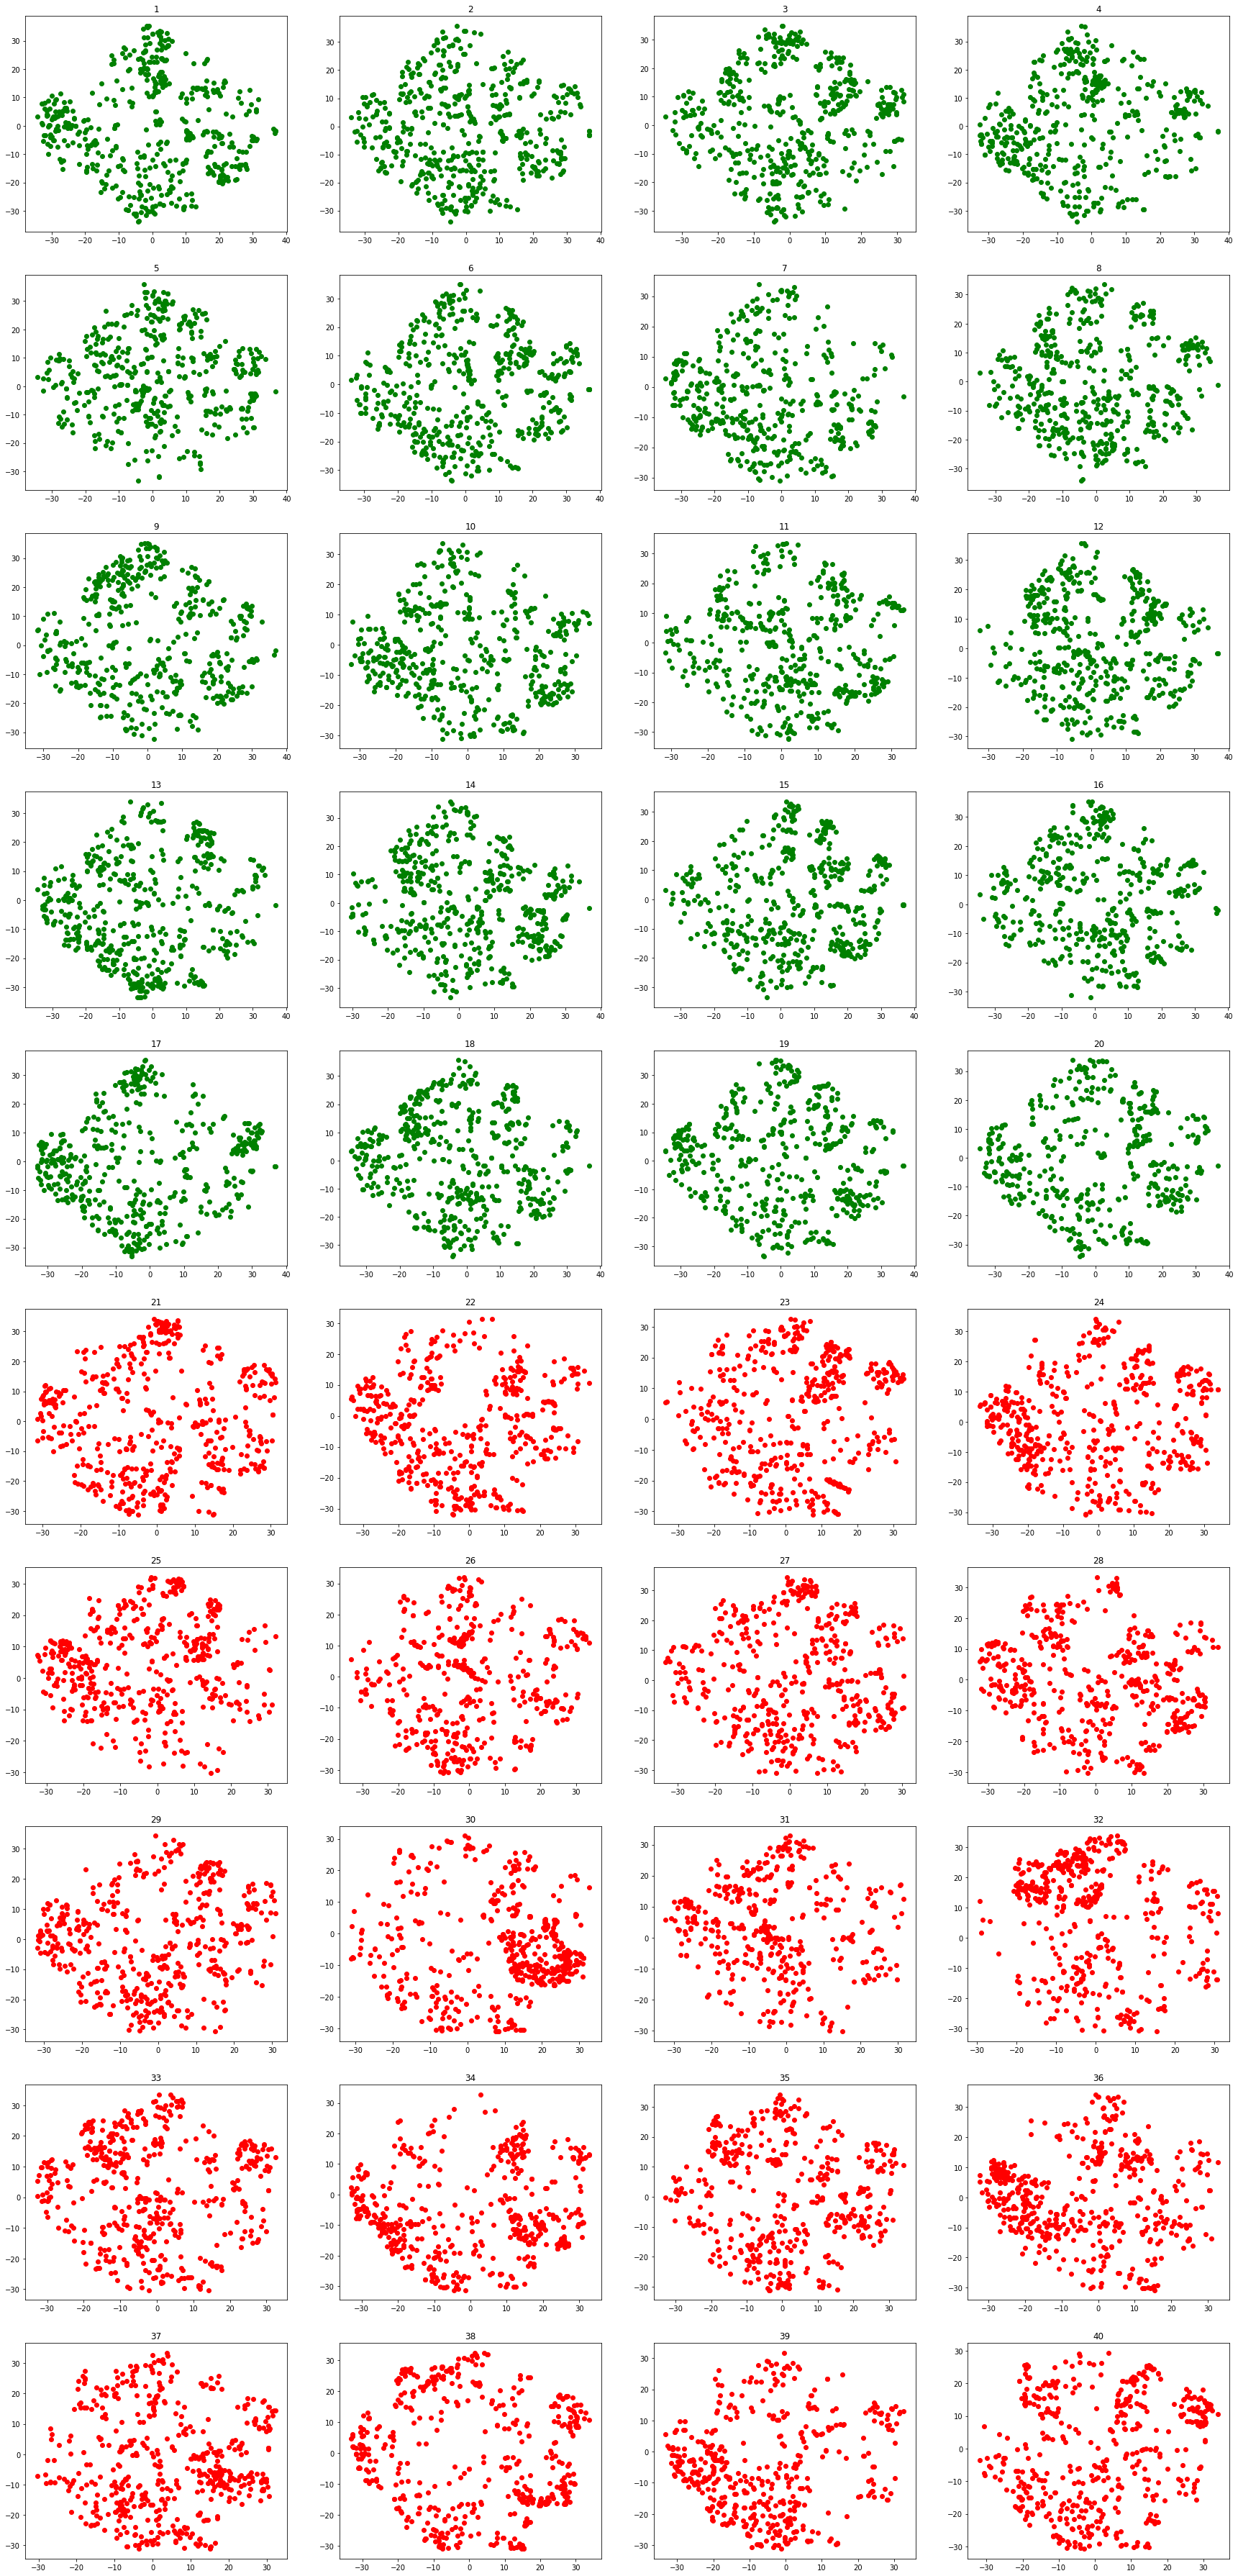

In [82]:
plot_each_patient(groupembedding_tSNE)

### Plot UMAP embedding

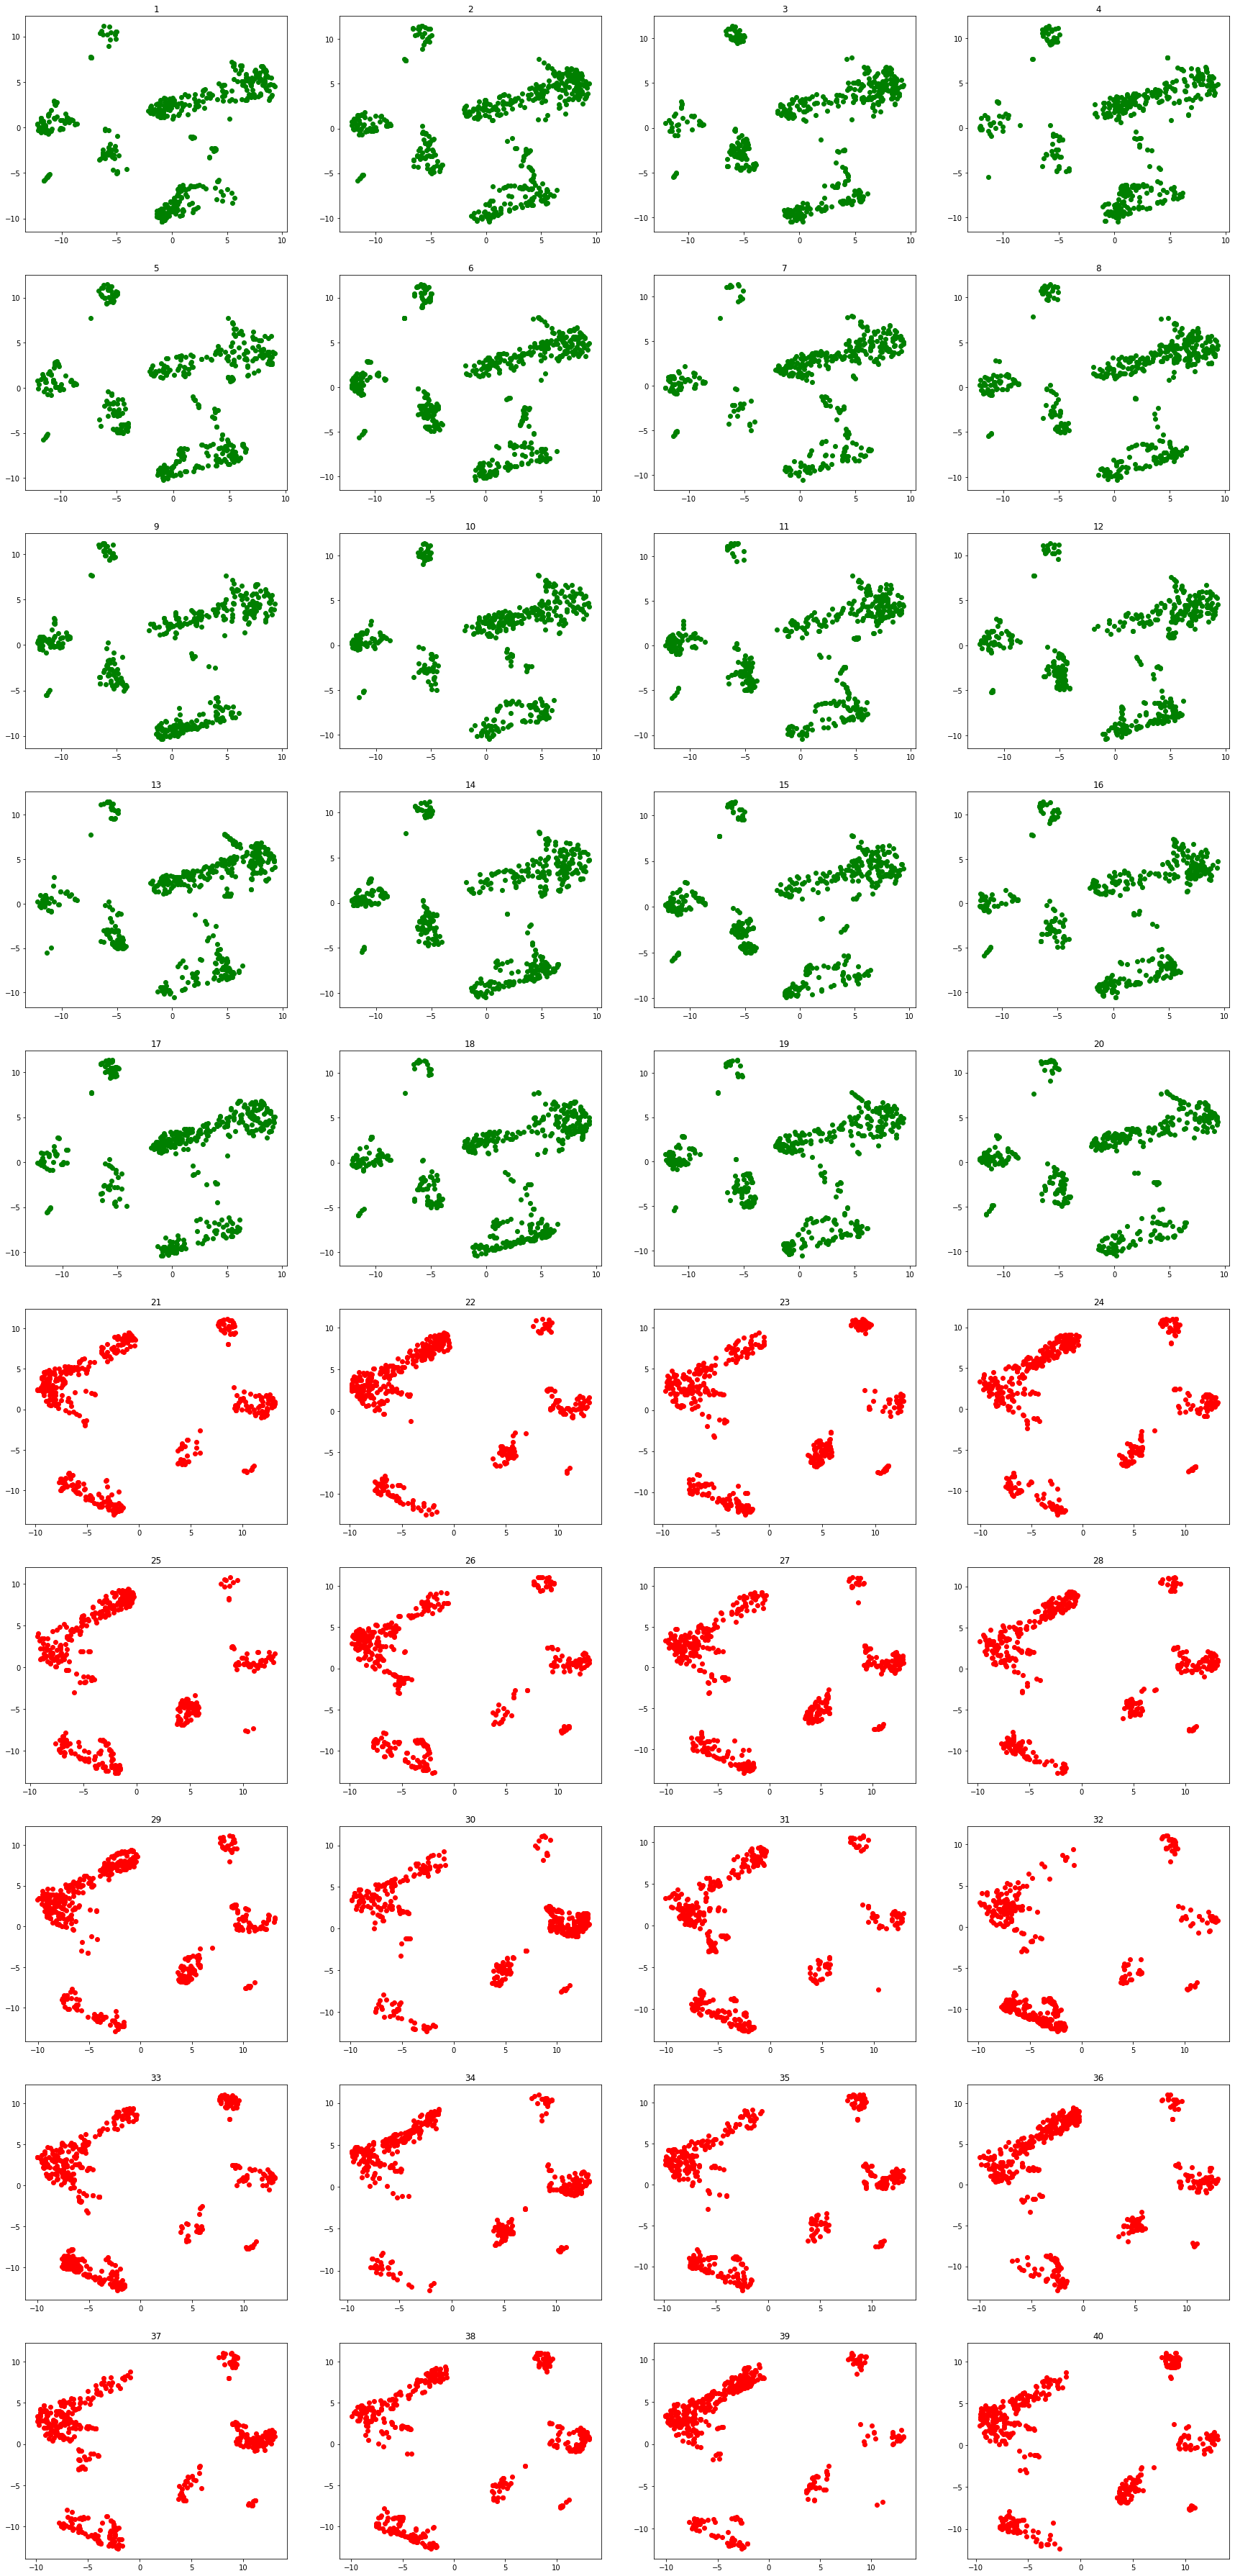

In [81]:
plot_each_patient(groupembedding_UMAP)

### Save the embeddings

In [20]:
np.save("groupembedding_tSNE",groupembedding_tSNE)
np.save("groupembedding_UMAP",groupembedding_UMAP)

## 3.  Embed each patient separately -> plot each patient separately

### Embedd 

In [15]:
patientembedding_tSNE = list()
patientembedding_UMAP = list()

tsne = TSNE(n_components=2, perplexity=30, 
            learning_rate=20, n_iter=1000, 
            random_state=0)
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)


for id_ in range(1,41):
    print(id_)
    patient = subsample[subsample.id == id_]
    patient_cells = patient[patient.columns.difference(["id","group"])]
    patientembedding_UMAP.append(up.fit_transform(patient_cells))
    patientembedding_tSNE.append(tsne.fit(patient_cells.values))

1
2


/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


3
4
5
6
7
8
9
10
11
12
13
14
15


/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


16
17
18
19
20
21
22


/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


39
40


### Ploter

In [37]:
def plot_patient(patientembedding):
    

    def trim_axs(axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        """
        axs = axs.flat
        for ax in axs[N:]:
            ax.remove()
        return axs[:N]
    
    def plotResP(ax, cells_of_id, id_nr):
        if(id_nr>20): 
            color= "red" # control patients
        else: 
            color ="green" # diseased patients
        ax.scatter(cells_of_id[:, 0], cells_of_id[:, 1], c=color)
        ax.set_title(id_nr)
    
    # for each patient plot embedding 
    fig, axs = plt.subplots(10,4,figsize = (30,65))
    axs = trim_axs(axs, 40)
    
    for id_  in range(0,40):
        cells_of_id = patientembedding[id_]
        plotResP(axs[id_], cells_of_id, id_+1)
        
    plt.show

### Plot tSNE

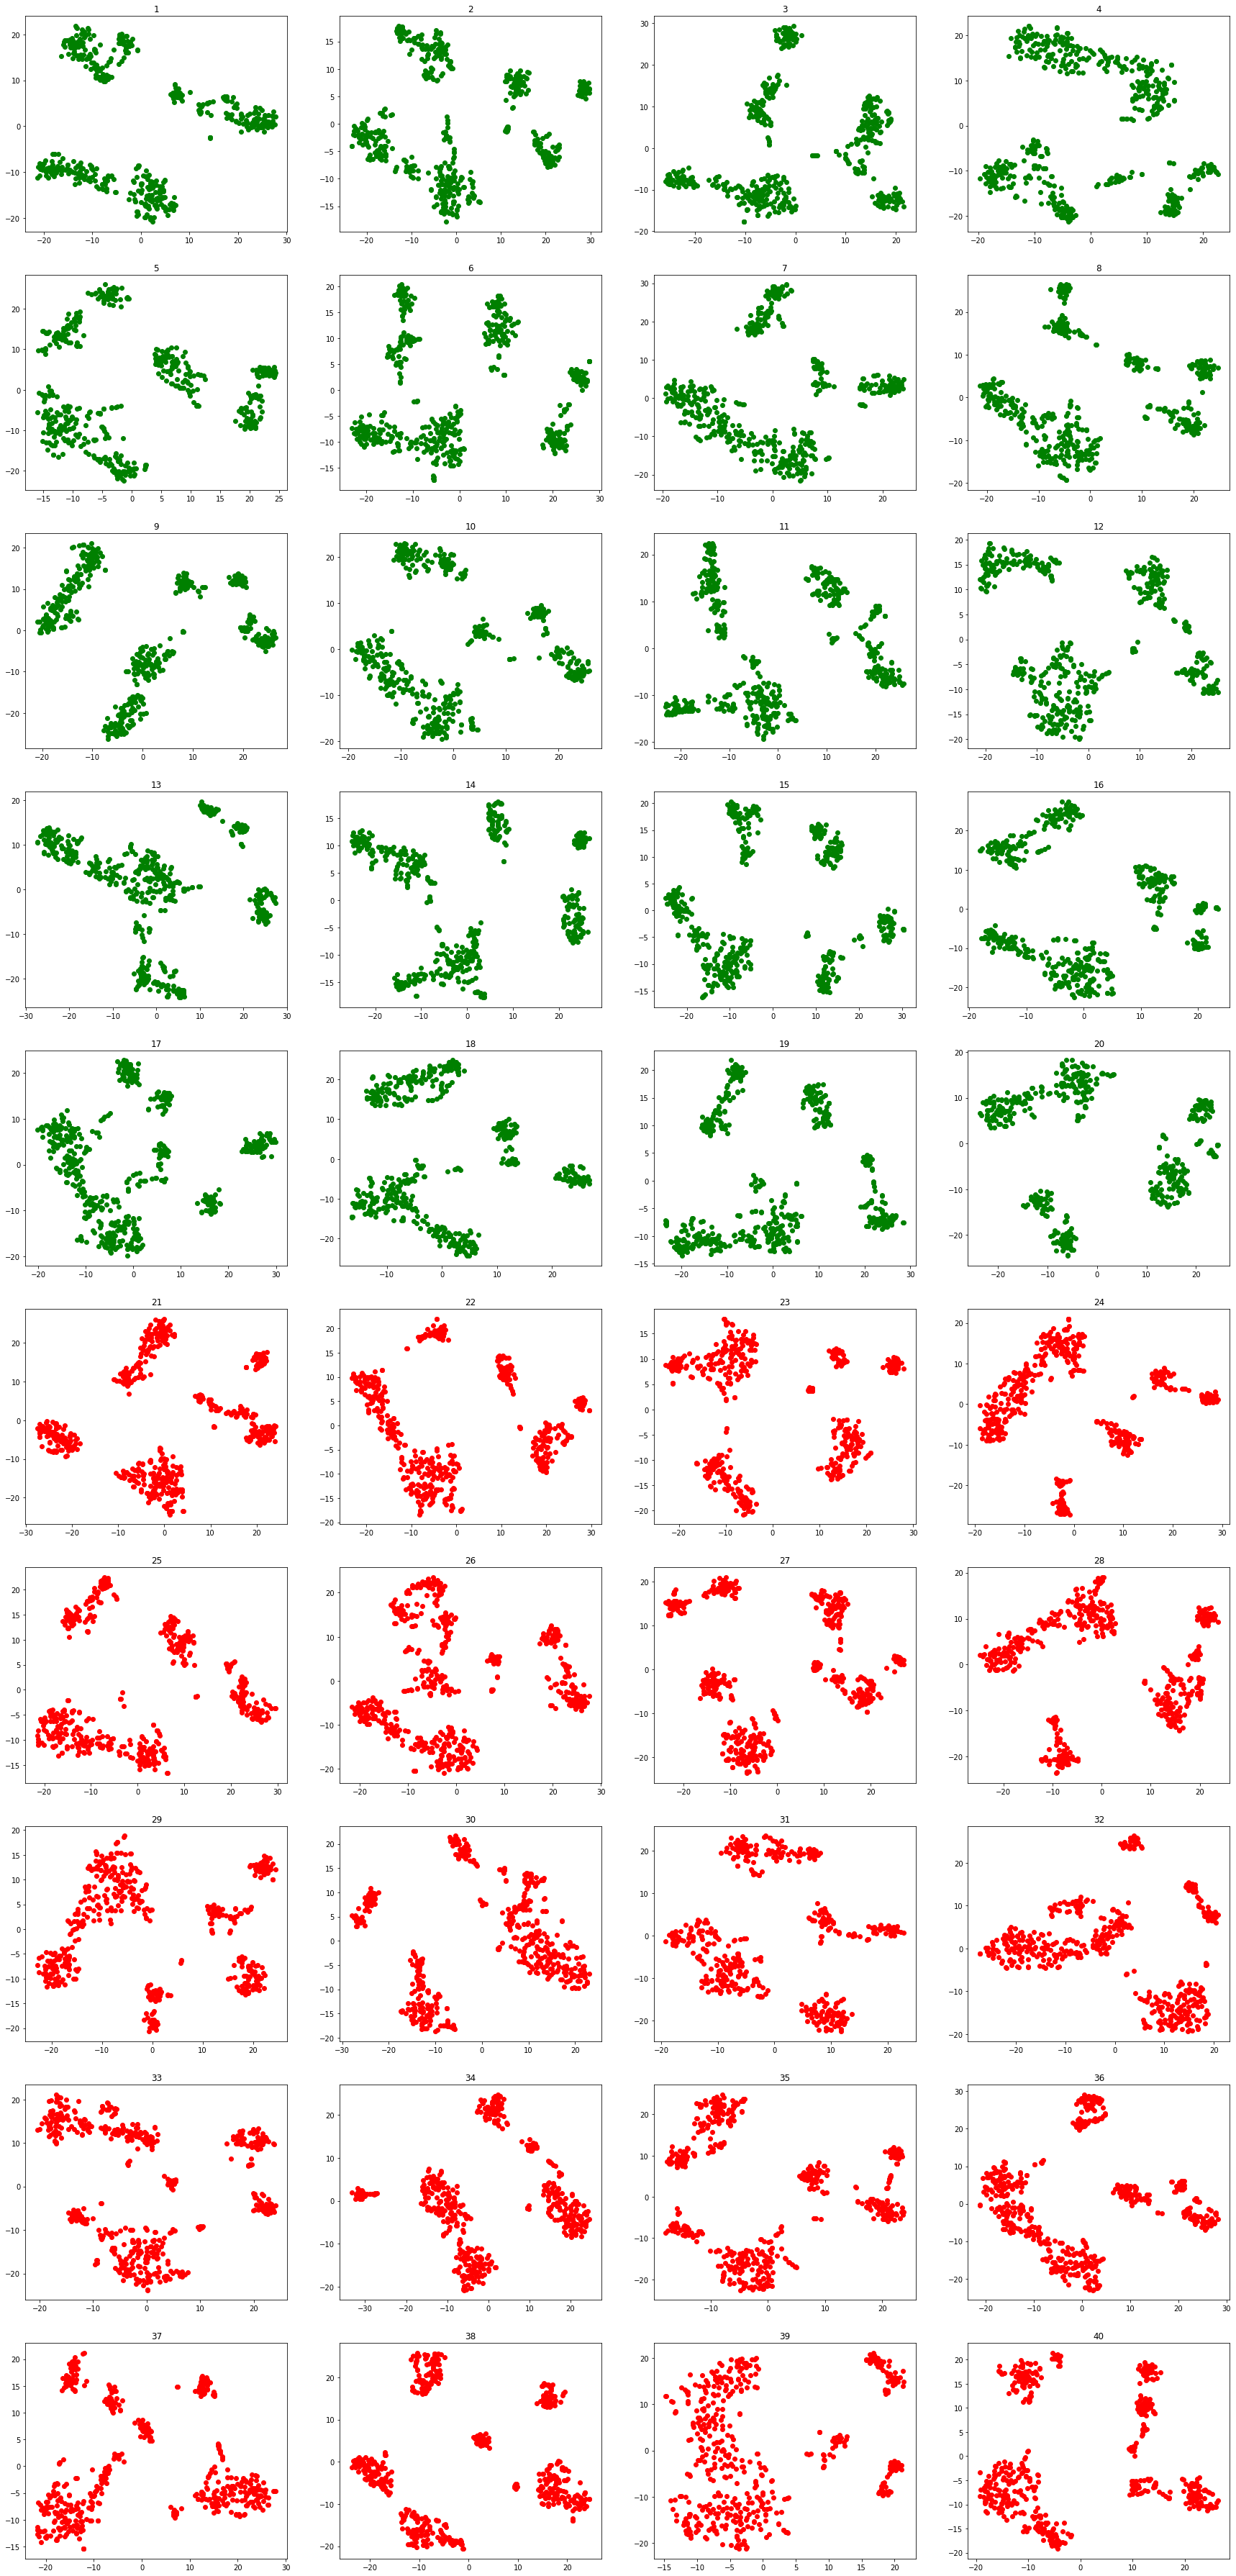

In [38]:
plot_patient(patientembedding_tSNE)

### Plot UMAP

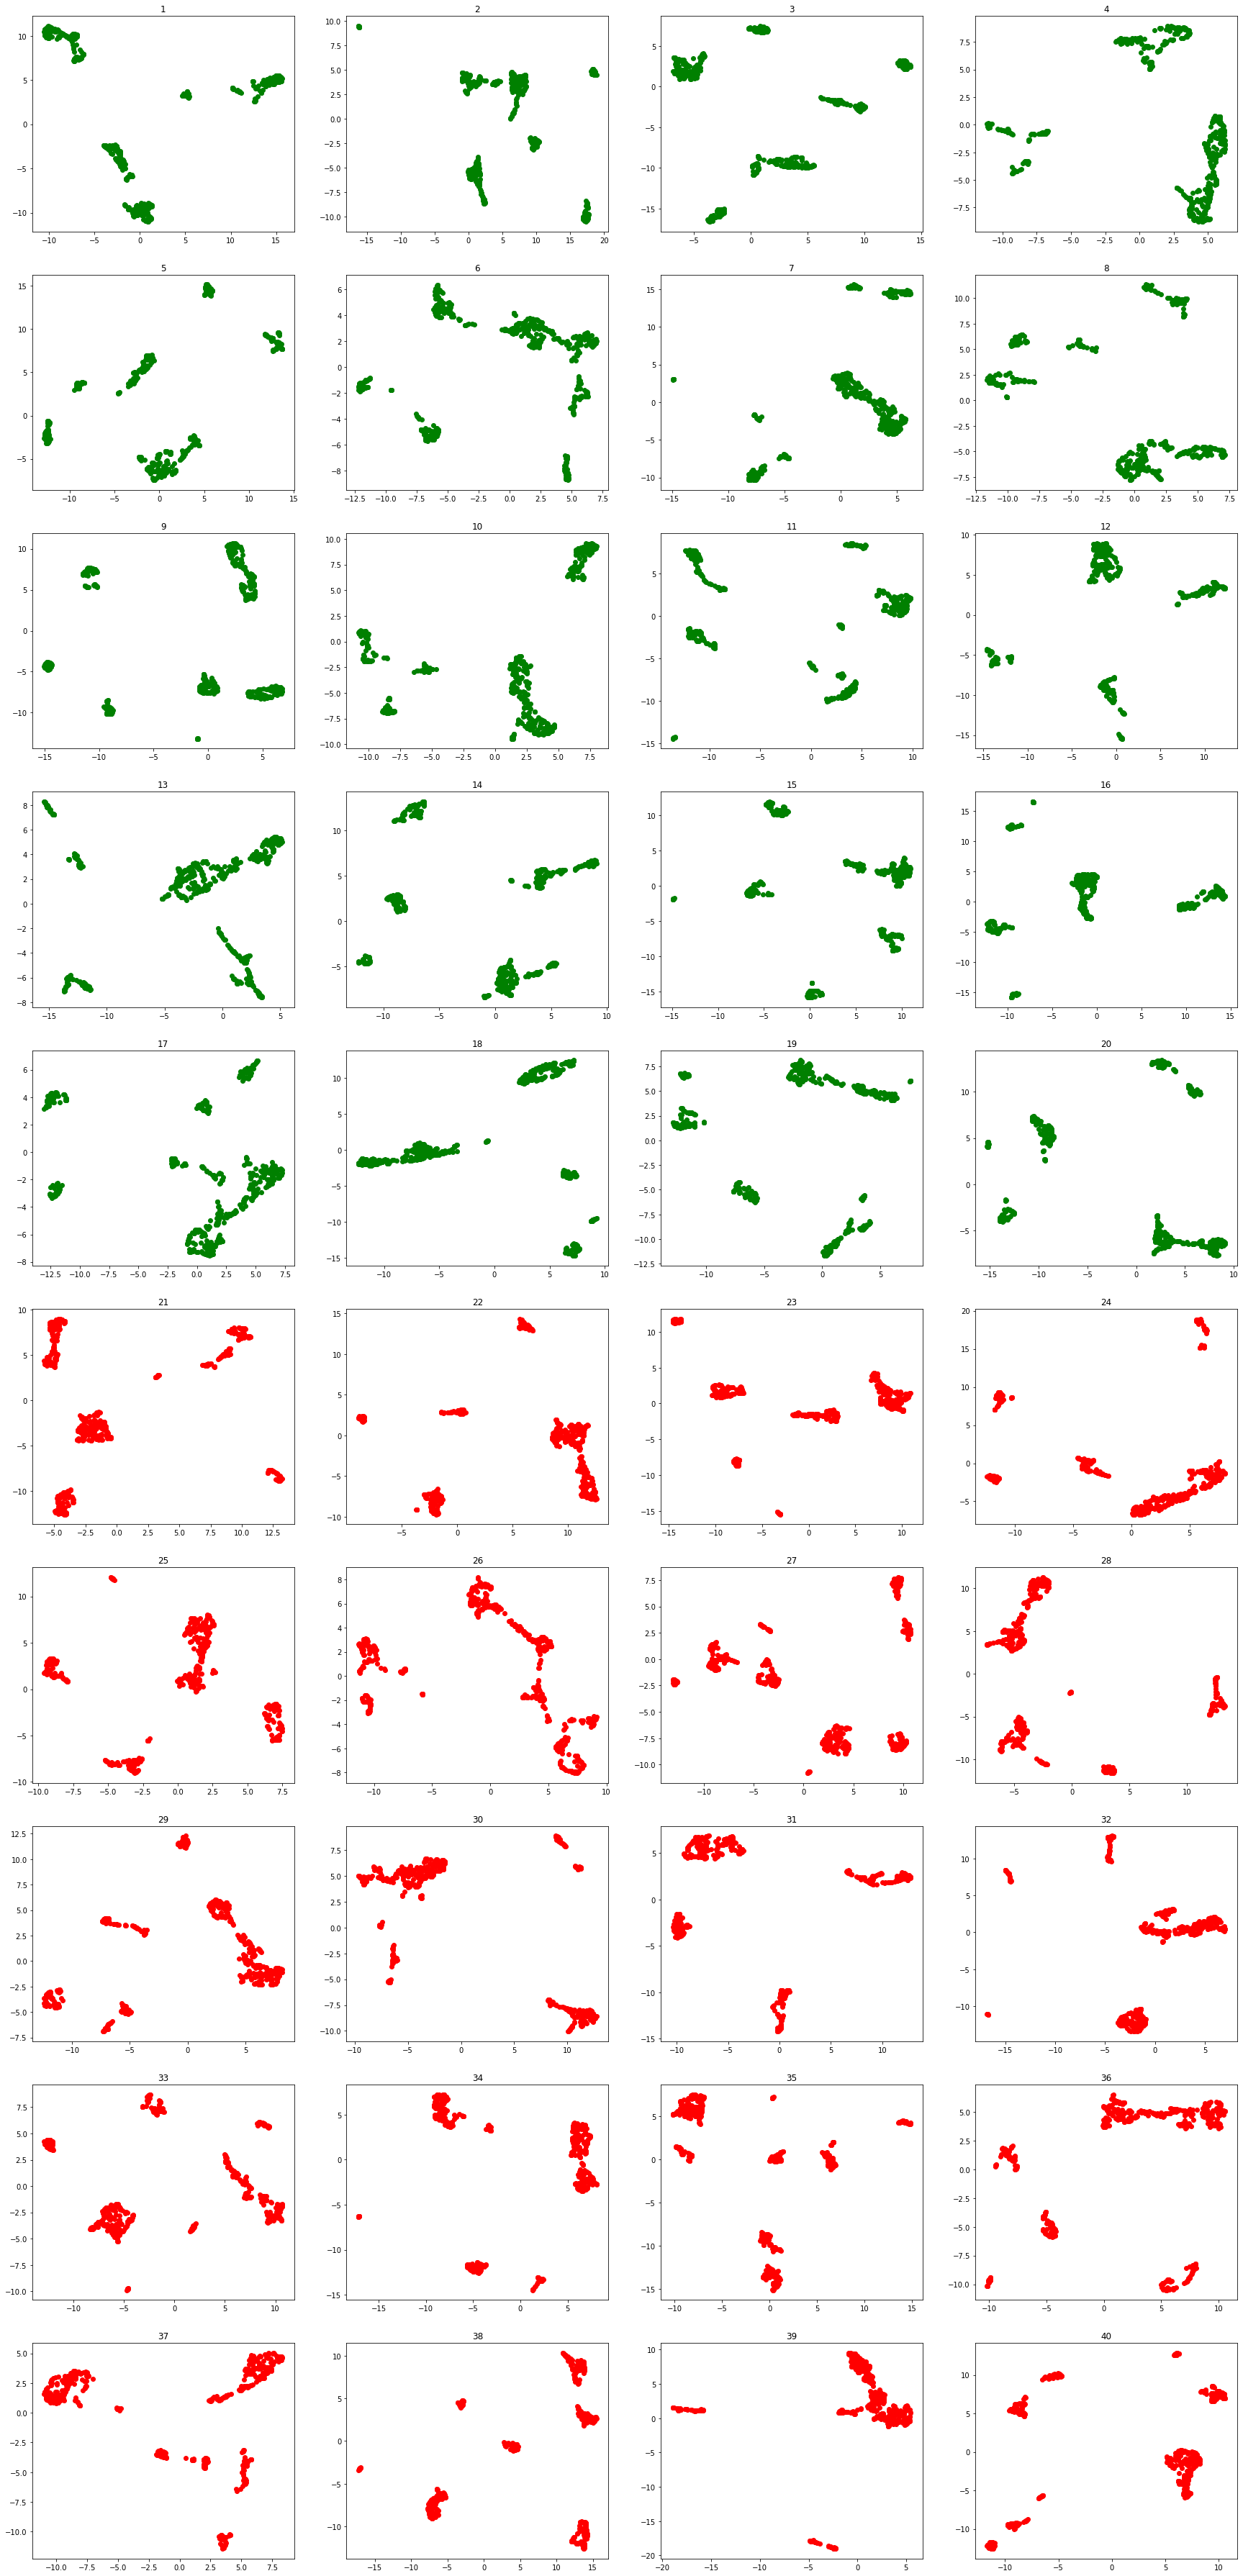

In [39]:
plot_patient(patientembedding_UMAP)

### Saving to file

In [9]:
np.save("tSNE_",tSNE_)
np.save("UMAP_",UMAP_)